<a href="https://www.kaggle.com/code/dingusagar/red-wine-quality-xgboost-classifier?scriptVersionId=192139606" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [201]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv


In [202]:
# Initialise W&B if you need tracking. 
track_experiment = True

if track_experiment:
    import wandb
    username = "dingusagar" 
    wandb.init(project="wine-quality-classification", entity=username)

In [203]:
DATAFILE = "/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv"

In [204]:
df = pd.read_csv(DATAFILE)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Some EDA first

In [205]:
# Summary statistics
print("\nSummary statistics:")
print(df.describe())


Summary statistics:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000         

In [206]:
# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())



Missing values in the dataset:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


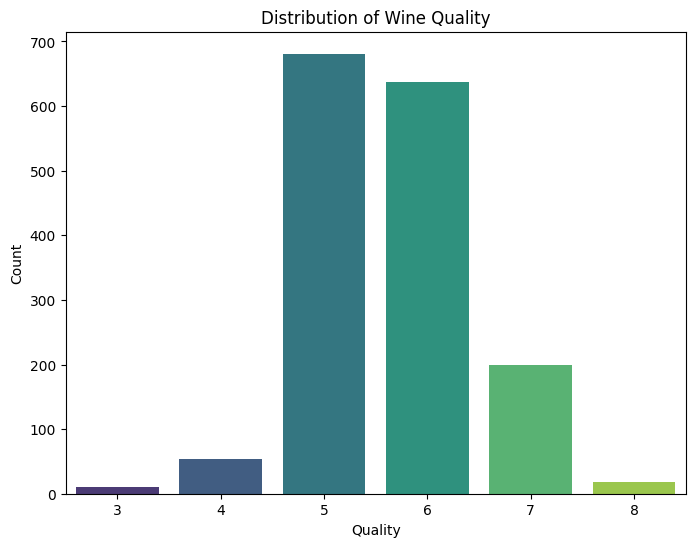

In [207]:
# Distribution of wine quality
plt.figure(figsize=(8, 6))
sns.countplot(x='quality', data=df, palette='viridis')
plt.title('Distribution of Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()


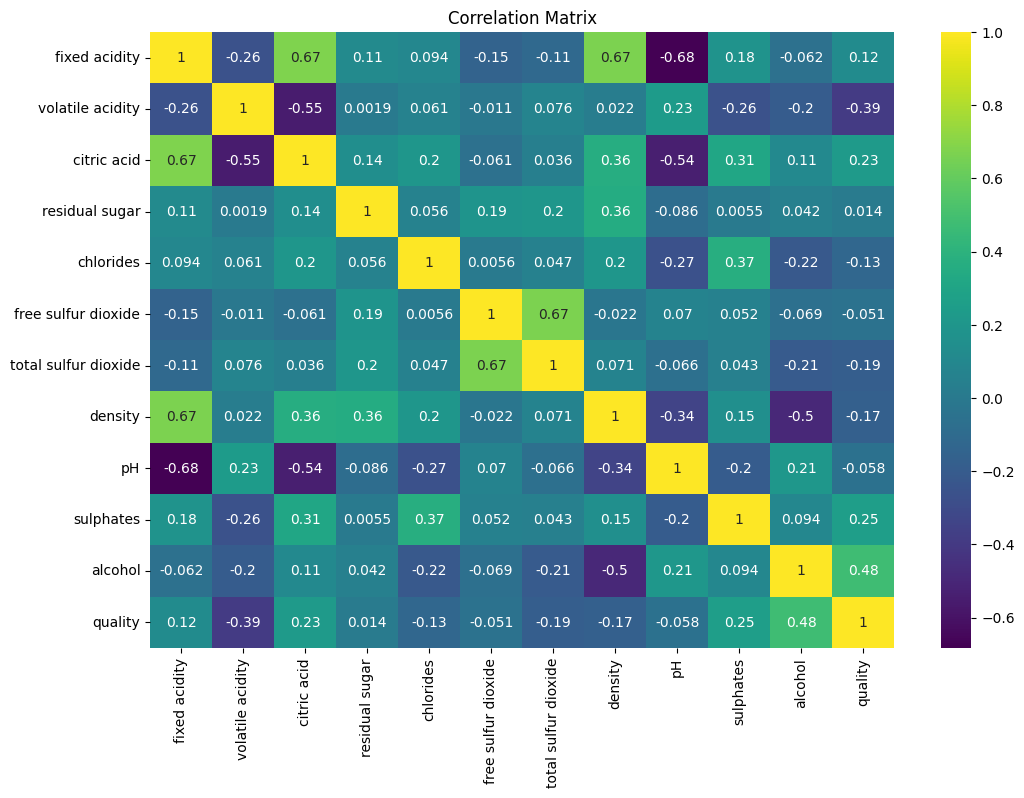

In [208]:
# Correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()


### Notes on Correlation
* Acidity and density are correlated
* Fixed acidity correlated to citric acid and density. 
* Fixed acidity is negatively correlated to pH. 
* Citric acid and volatice acidity are negatively correlated. 
* Obvious - total sulfur dioxide and free sulfur dioxide are correlated.

In [209]:
# Pairplot to see relationships between features
# sns.pairplot(df, hue='quality', palette='viridis')
# plt.suptitle('Pairplot of Features colored by Quality', y=1.02)
# plt.show()

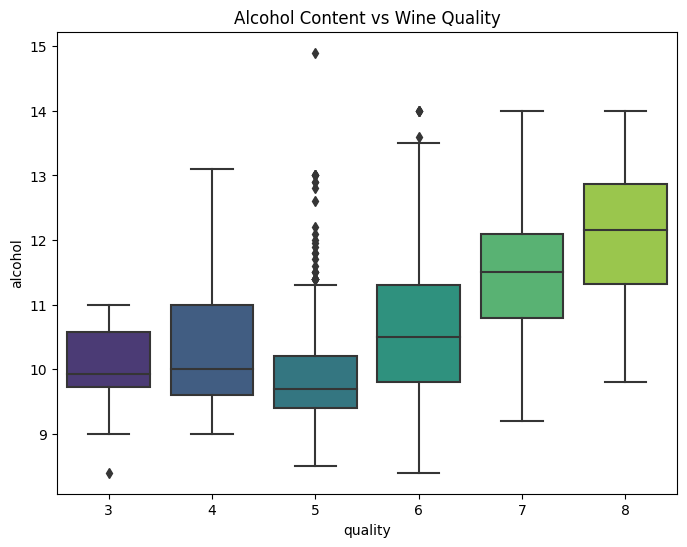

In [210]:
# Alcohol vs Quality
plt.figure(figsize=(8, 6))
sns.boxplot(x='quality', y='alcohol', data=df, palette='viridis')
plt.title('Alcohol Content vs Wine Quality')
plt.show()

### Notes on Alcohol content and Wine Quality
* The low quality wines (rating 3) have relativly small alcohol content. That does't mean wines with low alcohol content are low quality. 
* The general treand on mean of alochol content -> more alcohol on average is rated better. Check the trend of mean lines on the box plot. 
* See the outliers on rating 5. Some extremely alcoholic wines are rated average. 

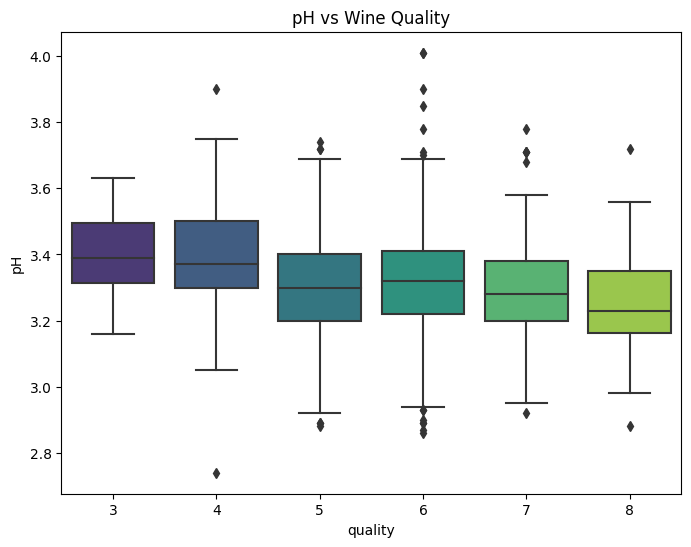

In [211]:
# pH vs Quality
plt.figure(figsize=(8, 6))
sns.boxplot(x='quality', y='pH', data=df, palette='viridis')
plt.title('pH vs Wine Quality')
plt.show()


### Notes on pH and Wine Quality
* The average pH is same across all ratings. 

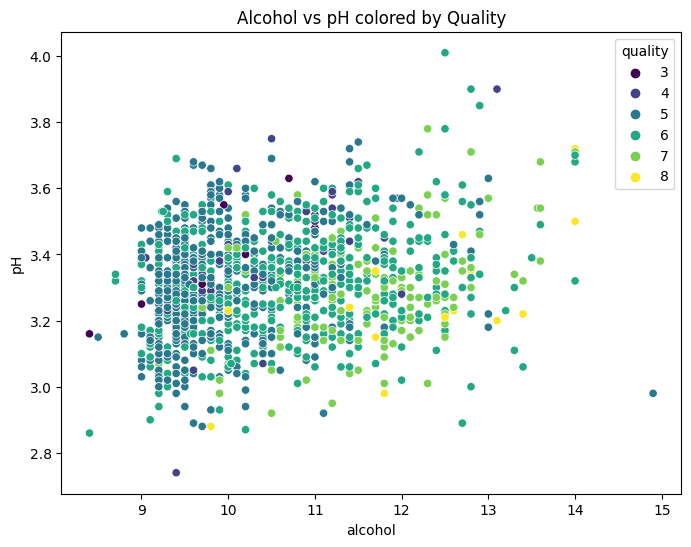

In [212]:
# Scatter plot of Alcohol vs pH colored by quality
plt.figure(figsize=(8, 6))
sns.scatterplot(x='alcohol', y='pH', hue='quality', palette='viridis', data=df)
plt.title('Alcohol vs pH colored by Quality')
plt.show()

# Train XGBoost Model 

### Hyperparams to Tune/Consider
* Loss  : mgloss , logloss
* Standard Scaler required ? Does't seem to impact. Common, its XGboost!
* If turning into binary classifier. need to check which threshold to split the classes. 

### Logs
(Aug 11, 2024)
* Turned into binary classification problem for simplicity. 
* Standard Scaler was useless for xgboost. Disabled that.
* binary class - threshold at 7 to split the classes. this creates a clas imbalance. 
* Trying to solve class imbalance using Upsampling. F1-score improved from 65 to 74

In [213]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import OrderedDict



In [214]:
config = OrderedDict({
    'sampling_strategy' : 'auto'
})


In [215]:
# Prepare the data
X = df.drop('quality', axis=1)  # Features
y = df['quality']               # Target variable

# Convert to binary classification: Good (6-8) vs Bad (3-5)
y = (y >= 7).astype(int)

# Label encoding for the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)



In [216]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [217]:
# Define a pipeline
pipeline = ImbPipeline([
    ('oversample', RandomOverSampler(random_state=42)), 
#     ('scaler', StandardScaler()),      
    ('xgb', XGBClassifier(eval_metric='logloss', use_label_encoder=True))  
])

In [218]:
# Train the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('oversample', RandomOverSampler(random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [223]:
# Make predictions
y_pred = pipeline.predict(X_test)
y_probas = pipeline.predict_proba(X_test)


In [224]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.93
Precision: 0.79
Recall: 0.69
F1-Score: 0.74

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       415
           1       0.79      0.69      0.74        65

    accuracy                           0.93       480
   macro avg       0.87      0.83      0.85       480
weighted avg       0.93      0.93      0.93       480



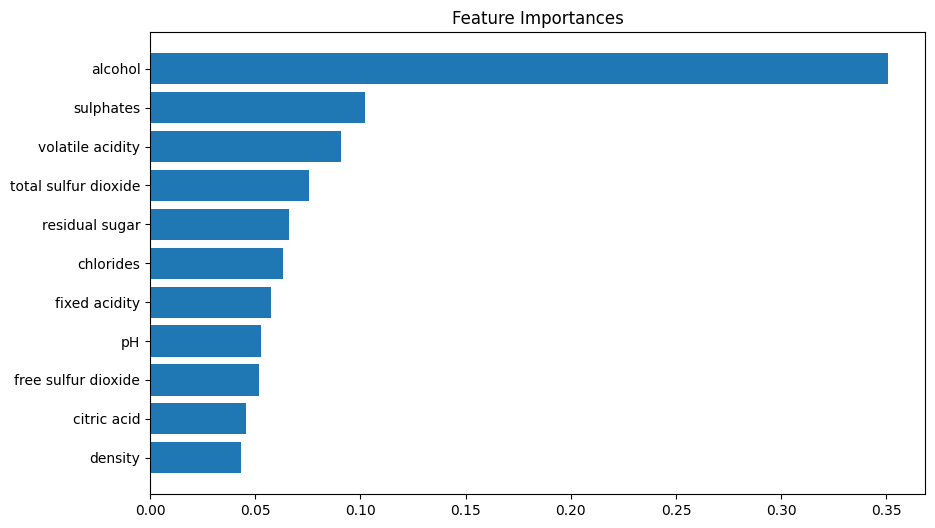

In [225]:
# Log feature importances
feature_importances = pipeline.named_steps['xgb'].feature_importances_
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(features_df['Feature'], features_df['Importance'])
plt.gca().invert_yaxis()
plt.show()


In [227]:
if track_experiment:
    comment = """Binary Classifier with default XGBoost parameters and auto sampling strategy"""
    
    wandb.config.update(config)
    wandb.log({"precision": precision, "recall": recall, "f1_score": f1, "accuracy" : accuracy})
    wandb.run.notes = comment

    # sklearn .
    wandb.sklearn.plot_classifier(pipeline.named_steps['xgb'], X_train, X_test, y_train, y_test, y_pred, y_probas, labels=["Bad", "Good"])
    wandb.sklearn.plot_confusion_matrix(y_test, y_pred, labels=["Bad", "Good"])
    wandb.finish()
    


wandb: 
wandb: Plotting Classifier.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


accuracy,▁▁▁
f1_score,▁▁▁
precision,▁▁▁
recall,▁▁▁
accuracy,0.93333
f1_score,0.7377
precision,0.78947
recall,0.69231


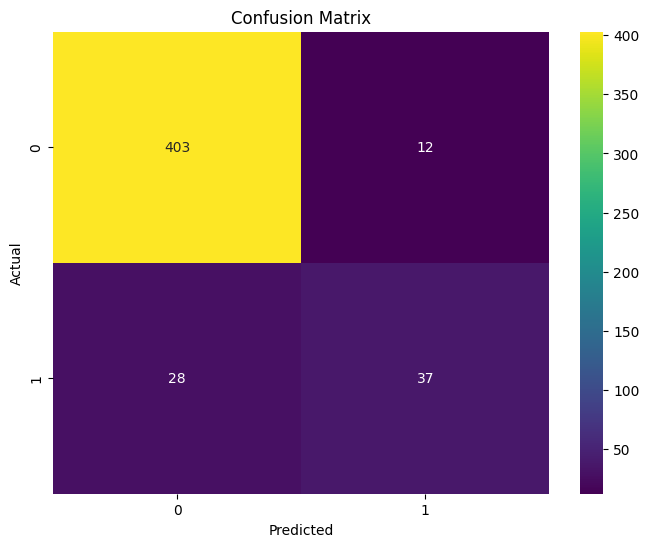

In [139]:
# Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Analysis 

### Notes on the baseline model.
* We have 81 acc. 
* Around 46 incorrect predictions on both the classes. 
* We can check the class imbalance, but its not likely the problem. 

array([[<Axes: title={'center': '0'}>]], dtype=object)

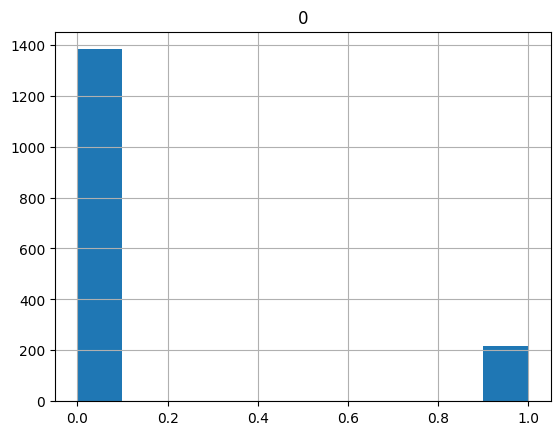

In [140]:
pd.DataFrame(y).hist()

class imbalance can happen!


# Hyperparameter Search 

In [123]:
# Define the hyperparameter grid
param_distributions = {
    'xgb__n_estimators': randint(50, 200),         # Number of trees
    'xgb__learning_rate': uniform(0.01, 0.3),      # Learning rate
    'xgb__max_depth': randint(3, 10),              # Maximum depth of trees
    'xgb__subsample': uniform(0.6, 1.0),           # Subsample ratio of the training instance
    'xgb__colsample_bytree': uniform(0.6, 1.0),    # Subsample ratio of columns
    'xgb__gamma': uniform(0, 0.5),                 # Minimum loss reduction required to make a further partition on a leaf node
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=50,   # Number of parameter settings that are sampled
    scoring='f1',  # Metric to optimize
    n_jobs=-1,     # Use all available cores
    cv=5,          # 5-fold cross-validation
    random_state=42,
    verbose=1
)


In [124]:
# Run the random search
random_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters found: ", random_search.best_params_)

# Best model
best_model = random_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
205 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.10/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/opt/conda/lib/python3.10/site-packages/xgboos

Best parameters found:  {'xgb__colsample_bytree': 0.9243450210052739, 'xgb__gamma': 0.061043977350336676, 'xgb__learning_rate': 0.11688935142309247, 'xgb__max_depth': 8, 'xgb__n_estimators': 178, 'xgb__subsample': 0.8279351625419417}
Accuracy: 0.80
Precision: 0.81
Recall: 0.81
F1-Score: 0.81
